<a href="https://colab.research.google.com/github/cht123/DSS_Class_Notes/blob/master/left_right_center_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [0]:
import pandas as pd
from random import choice
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor

#Game functions

In [0]:
def roll_dice(dice):

  '''Roll the dice for the round'''

  d1_pos = choice(dice)
  d2_pos = choice(dice)
  d3_pos = choice(dice)

  return d1_pos, d2_pos, d3_pos

In [0]:
def pay(turn, player, player_bank, player_moves):

  '''Determine the actions once the dice are rolled'''

  l_player = player_moves[player][1][0]
  r_player = player_moves[player][1][1]
  l_player_add = 0
  r_player_add = 0
  pot_add = 0
  roll = 0

  if player_bank[player] >2:
    roll = 3
  elif player_bank[player] ==2:
    roll = 2
  elif player_bank[player] ==1:
    roll = 1
  else:
    roll = 0
  for i in range(roll):
    if turn[i] == 'R':
      r_player_add = r_player_add + 1
    elif turn[i] == 'L':
      l_player_add = l_player_add + 1
    elif turn[i] == 'C':
      pot_add = pot_add + 1
    else:
      None
  return l_player, l_player_add, r_player, r_player_add, pot_add

In [0]:
def print_begin(p, player_bank, pot):
  print('------------------------------------------------------------------------------')
  print('Player {} is rolling and has {}'.format(p, player_bank[p]))
  print('The pot is at {}'.format(pot))

In [0]:
def print_end(turn, pot, player_bank, nz_player_bank, round_count):
  print('The dice are: {}'.format(turn))
  print('The pot ends at {}'.format(pot))
  print('The player bank is: {}'.format(player_bank))
  print('The nonzero bank is: {}'.format(nz_player_bank))
  print('{} players still have money'.format(len(nz_player_bank)))
  print('Round: {}'.format(round_count))
  

In [0]:
def run_game(sim, player_count, dollars):
  
  game_detail = pd.DataFrame(columns=['round_count', 'player', 'dice_1', 'dice_2', 'dice_3', 'pot'])
  dice = ['L', 'R', 'C', 'DOT', 'DOT', 'DOT']
  pot = 0
  round_count = 0
  all_data = []

  player = [i for i in range(0,player_count)]
  player_bank = {i:dollars for i in range(0,player_count)}
  player_moves = [[i, [player[player.index(i)-1], 0]] if i == player_count -1 else [i, [player[player.index(i)-1], player.index(i)+1]] for i in player]

  going = True
  while going:
    
    for p in player:
      
      # print_begin(p, player_bank, pot)
      round_data = []
      round_count+=1

      if player_bank[p] > 0:
        
        # roll the dice
        turn = roll_dice(dice)
        
        # determine who paid gets paid and how much
        dist = player_moves[p]
        result = pay(turn, p, player_bank, player_moves)
        
        # distribute money
        player_bank[result[0]] = player_bank[result[0]] + result[1]
        player_bank[result[2]] = player_bank[result[2]] + result[3]
        pot = pot + result[4]
        player_bank[p] = player_bank[p] - (result[1] + result[3] + result[4])
        nz_player_bank = {k:v for (k,v) in player_bank.items() if v>0}
        
      
      # print_end(turn, pot, player_bank, nz_player_bank, round_count)

      round_data = [sim, player_count, dollars, round_count, pot, player_count * dollars]

      all_data.append(round_data)
      
      if len(nz_player_bank) == 1:
        going = False
        break

  return all_data

In [0]:
def run_sim(s, p, d):

  sim_data = []

  for r in range(s):
    data = run_game(r,p,d)
    sim_data.append(data)
    
  return sim_data

In [0]:
big_sim = run_sim(5000, 20, 5)

In [0]:
def convert_list(input_list):

  k = []

  for i in range(len(input_list)):
    for j in range(len(input_list[i])):
      k.append(input_list[i][j])
  data_df = pd.DataFrame(data = k, columns = ['sim', 'player_count', 'dollars', 'round_count', 'pot', 'total_dollars'])

  return data_df

In [0]:
data_df = convert_list(big_sim)

In [0]:
hist_data = data_df.sort_values('round_count').drop_duplicates(['sim'],keep='last')

(array([4.200e+01, 6.970e+02, 1.908e+03, 1.466e+03, 6.420e+02, 1.920e+02,
        3.900e+01, 9.000e+00, 4.000e+00, 1.000e+00]),
 array([240. , 308.1, 376.2, 444.3, 512.4, 580.5, 648.6, 716.7, 784.8,
        852.9, 921. ]),
 <a list of 10 Patch objects>)

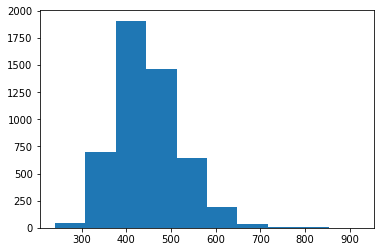

In [0]:
plt.hist(hist_data['round_count'])

In [0]:
mean = hist_data['round_count'].mean()
median = hist_data['round_count'].median()
min = hist_data['round_count'].min()
max = hist_data['round_count'].max()
std = hist_data['round_count'].std()
UCL = mean + 3 * std
LCL = mean - 3 * std

In [0]:
print('Mean: {}'.format(mean))
print('Median: {}'.format(median))
print('Min: {}'.format(min))
print('Max: {}'.format(max))
print('Std: {}'.format(std))
print('UCL: {}'.format(UCL))
print('LCL: {}'.format(LCL))

Mean: 447.6968
Median: 439.0
Min: 240
Max: 921
Std: 73.03062072906712
UCL: 666.7886621872013
LCL: 228.60493781279862


# Run random games to build a model

In [0]:
def run_rand_sim(s, p, d):

  sim_data = []

  if p < 3 or d < 2:
    print('Players must be greater than 2 and dollars must be greater than 1')
  
  else:

    for r in range(s):

      prand = choice(range(2,p))
      drand = choice(range(1,d))
      data = run_game(r,prand,drand)
      sim_data.append(data)
    
  return sim_data

In [0]:
rand_sim = run_rand_sim(10000, 20, 10)

In [0]:
rand_data_df = convert_list(rand_sim)

In [0]:
rand_hist_data = rand_data_df.sort_values('round_count').drop_duplicates(['sim'],keep='last')

In [0]:
rand_hist_data

,sim,player_count,dollars,round_count,pot,total_dollars
1576067,7704,2,1,1,0,2
218880,1070,2,1,1,0,2
1717193,8382,2,1,1,1,2
1707912,8337,2,1,1,0,2
1644139,8033,2,3,1,0,6
...,...,...,...,...,...,...
521886,2507,16,9,804,143,144
1229701,5962,18,9,821,161,162
1442223,7058,19,9,823,169,171
1253215,6079,19,9,829,170,171


In [0]:
rand_hist_data.iloc[:,1: 3]

,player_count,dollars
1576067,2,1
218880,2,1
1717193,2,1
1707912,2,1
1644139,2,3
...,...,...
521886,16,9
1229701,18,9
1442223,19,9
1253215,19,9


#Split train/ test

In [0]:
# Get the featuers and labels
X = rand_hist_data.iloc[:,1:3]
y = rand_hist_data.iloc[:, 3]

In [0]:
x_training_set, x_test_set, y_training_set, y_test_set = train_test_split(X,y,test_size=0.10, random_state=42, shuffle=True)

In [0]:
n_estimators=100
# Fit regression model
# Estimate the score on the entire dataset, with no missing values
model = RandomForestRegressor(random_state=0, n_estimators=n_estimators)
model.fit(x_training_set, y_training_set)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [0]:
from sklearn.metrics import mean_squared_error, r2_score
model_score = model.score(x_training_set,y_training_set)
# Have a look at R sq to give an idea of the fit ,
# Explained variance score: 1 is perfect prediction
print('coefficient of determination R^2 of the prediction: {}'.format(model_score))
y_predicted = model.predict(x_test_set)

# The mean squared error
print("Mean squared error: %.2f"% mean_squared_error(y_test_set, y_predicted))
# Explained variance score: 1 is perfect prediction
print('Test Variance score: %.2f' % r2_score(y_test_set, y_predicted))

# The mean absolute error
errors = abs(y_predicted - y_test_set)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'rounds.')


coefficient of determination R^2 of the prediction: 0.9221786996751233
Mean squared error: 2077.99
Test Variance score: 0.91
Mean Absolute Error: 31.72 rounds.


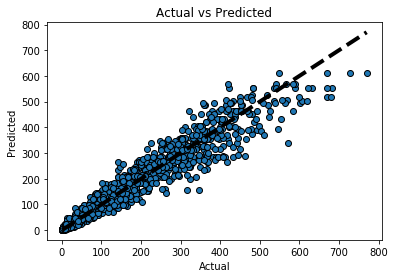

In [0]:
from sklearn.model_selection import cross_val_predict

fig, ax = plt.subplots()

ax.scatter(y_test_set, y_predicted, edgecolors=(0, 0, 0))

ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()], 'k--', lw=4)

ax.set_xlabel('Actual')

ax.set_ylabel('Predicted')

ax.set_title("Actual vs Predicted")

plt.show()

In [0]:
importances = list(model.feature_importances_)

In [0]:
importances

[0.7321194313299865, 0.2678805686700136]